<a href="https://colab.research.google.com/github/SamMilnes/Weather-Prediction-Models-By-Country/blob/main/Analysis_By_Country.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
all_countries = pd.read_csv('/content/gdrive/MyDrive/Data Science Group Project/GlobalLandTemperaturesByCountry.csv')
len(all_countries)
# all_countries["Country"].unique()

577462

In [3]:
united_states = all_countries[all_countries["Country"] == "United States"]
afghanistan = all_countries[all_countries["Country"] == "Afghanistan"]
bangladesh = all_countries[all_countries["Country"] == "Bangladesh"]
chad = all_countries[all_countries["Country"] == "Chad"]
haiti = all_countries[all_countries["Country"] == "Haiti"]

In [4]:
lst = [united_states, afghanistan, bangladesh, chad, haiti]
lst_string = ["United States", "Afghanistan", "Bangladesh", "Chad", "Haiti"]
for i in range(0, len(lst)):
  print(lst_string[i], "dataframe has", len(lst[i]), "rows")

United States dataframe has 2941 rows
Afghanistan dataframe has 2106 rows
Bangladesh dataframe has 2613 rows
Chad dataframe has 1893 rows
Haiti dataframe has 2277 rows


# LSTM Time Series Models For Each Country

In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import History
from tensorflow.keras.models import load_model

In [6]:
# This function is used to make our LSTM Models for each country
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+5]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [7]:
# This function will be used to clean the dataframes, ie drop na values and get only the date and temperture columns
def clean_df(df):
  temp = df.copy()
  temp = temp[["dt", "AverageTemperature"]]
  temp = temp.dropna()
  temp["Date"] = pd.to_datetime(temp.dt, format='%Y-%m-%d')
  temp = temp[["Date", "AverageTemperature"]]

  just_temp_df = temp["AverageTemperature"]

  return temp, just_temp_df

In [8]:
# This function will be used to get the lengths for train, val and test data
import math
def get_lengths(df):
  # print(len(df))
  train = int(len(df) * .90)
  val = int(len(df) * .04)
  test = int(len(df) * .06)

  # print(train + val + test)

  return train, val, test

# United States

In [9]:
united_states_final, united_states_temp_only = clean_df(united_states)
# united_states_final.head()
WINDOW_SIZE = 5
X, y = df_to_X_y(united_states_temp_only, WINDOW_SIZE)
X.shape, y.shape

((2477, 5, 1), (2477,))

In [10]:
train_len, val_len, test_len = get_lengths(united_states_temp_only)
# print(train_len, val_len, test_len)
X_train, y_train = X[:train_len], y[:train_len]
X_val, y_val = X[train_len:(val_len+train_len)], y[train_len:(val_len+train_len)]
X_test, y_test = X[(val_len+train_len):], y[(val_len+train_len):]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2233, 5, 1), (2233,), (99, 5, 1), (99,), (145, 5, 1), (145,))

In [11]:
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [12]:
cp = ModelCheckpoint('us_model/', save_best_only=True)
history = History()
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [13]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp, history])

Epoch 1/10
66/70 [===========================>..] - ETA: 0s - loss: 94.0641 - root_mean_squared_error: 9.6987  

70/70 [==============================] - 26s 242ms/step - loss: 90.8543 - root_mean_squared_error: 9.5318 - val_loss: 29.0122 - val_root_mean_squared_error: 5.3863
Epoch 2/10
64/70 [==========================>...] - ETA: 0s - loss: 8.2890 - root_mean_squared_error: 2.8791

70/70 [==============================] - 5s 77ms/step - loss: 7.9103 - root_mean_squared_error: 2.8125 - val_loss: 2.2384 - val_root_mean_squared_error: 1.4961
Epoch 3/10
63/70 [==========================>...] - ETA: 0s - loss: 2.8903 - root_mean_squared_error: 1.7001

70/70 [==============================] - 6s 82ms/step - loss: 2.7702 - root_mean_squared_error: 1.6644 - val_loss: 1.4661 - val_root_mean_squared_error: 1.2108
Epoch 4/10
70/70 [==============================] - 0s 6ms/step - loss: 2.1761 - root_mean_squared_error: 1.4752 - val_loss: 1.6010 - val_root_mean_squared_error: 1.2653
Epoch 5/10
70/70 [==============================] - 0s 7ms/step - loss: 2.0171 - root_mean_squared_error: 1.4202 - val_loss: 1.4956 - val_root_mean_squared_error: 1.2229
Epoch 6/10
70/70 [==============================] - 0s 6ms/step - loss: 1.9740 - root_mean_squared_error: 1.4050 - val_loss: 1.7817 - val_root_mean_squared_error: 1.3348
Epoch 7/10
70/70 [==============================] - 0s 6ms/step - loss: 1.9369 - root_mean_squared_error: 1.3917 - val_loss: 1.5664 - val_root_mean_squared_error: 1.2516
Epoch 8/10
65/70 [==========================>...] - ETA: 0s - loss: 1.8825 - root_mean_squared_error: 1.3720

70/70 [==============================] - 5s 74ms/step - loss: 1.9123 - root_mean_squared_error: 1.3828 - val_loss: 1.3464 - val_root_mean_squared_error: 1.1604
Epoch 9/10
67/70 [===========================>..] - ETA: 0s - loss: 1.8165 - root_mean_squared_error: 1.3478

70/70 [==============================] - 6s 81ms/step - loss: 1.8598 - root_mean_squared_error: 1.3637 - val_loss: 1.3444 - val_root_mean_squared_error: 1.1595
Epoch 10/10
70/70 [==============================] - 0s 6ms/step - loss: 1.8582 - root_mean_squared_error: 1.3632 - val_loss: 1.3855 - val_root_mean_squared_error: 1.1771


Text(0.5, 1.0, 'Val Loss')

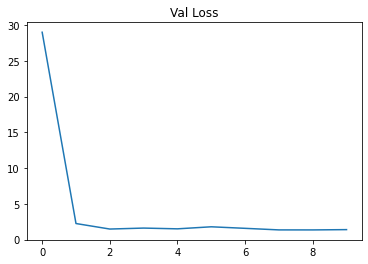

In [14]:
plt.plot(model1.history.history['val_loss'])
plt.title('Val Loss')

In [15]:
model1 = load_model('us_model/')
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})
# train_results

70/70 [==============================] - 1s 3ms/step


In [16]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})
test_results["Difference"] = abs(test_results["Actuals"] - test_results["Test Predictions"])
# test_results
united_states_average_accuracy = test_results["Difference"].mean()
print("On Average, the mean difference between our predictions and actuals for our", len(test_results), "test data points is:", united_states_average_accuracy)

5/5 [==============================] - 0s 4ms/step
On Average, the mean difference between our predictions and actuals for our 145 test data points is: 0.9251072417292103


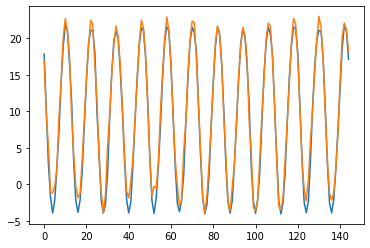

In [17]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

# Afghanistan

In [18]:
afghanistan_final, afghanistan_final_temp_only = clean_df(afghanistan)
# united_states_final.head()
WINDOW_SIZE = 5
afghanistan_X, afghanistan_y = df_to_X_y(afghanistan_final_temp_only, WINDOW_SIZE)
afghanistan_X.shape, afghanistan_y.shape

((2080, 5, 1), (2080,))

In [19]:
afghanistan_train_len, afghanistan_val_len, afghanistan_test_len = get_lengths(afghanistan_final_temp_only)
print(afghanistan_train_len, afghanistan_val_len, afghanistan_test_len)
afghanistan_X_train, afghanistan_y_train = afghanistan_X[:afghanistan_train_len], afghanistan_y[:afghanistan_train_len]
afghanistan_X_val, afghanistan_y_val = afghanistan_X[afghanistan_train_len:(afghanistan_val_len+afghanistan_train_len)], afghanistan_y[afghanistan_train_len:(afghanistan_val_len+afghanistan_train_len)]
afghanistan_X_test, afghanistan_y_test = afghanistan_X[(afghanistan_val_len+afghanistan_train_len):], afghanistan_y[(afghanistan_val_len+afghanistan_train_len):]
afghanistan_X_train.shape, afghanistan_y_train.shape, afghanistan_X_val.shape, afghanistan_y_val.shape, afghanistan_X_test.shape, afghanistan_y_test.shape

1876 83 125


((1876, 5, 1), (1876,), (83, 5, 1), (83,), (121, 5, 1), (121,))

In [20]:
afghan_model = Sequential()
afghan_model.add(InputLayer((5,1)))
afghan_model.add(LSTM(64))
afghan_model.add(Dense(8, 'relu'))
afghan_model.add(Dense(1, 'linear'))

afghan_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [30]:
afghan_cp = ModelCheckpoint('afghan_model/', save_best_only=True)
afghan_history = History()
afghan_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [31]:
afghan_model.fit(afghanistan_X_train, afghanistan_y_train, validation_data=(afghanistan_X_val, afghanistan_y_val), epochs=10, callbacks=[afghan_cp, afghan_history])

Epoch 1/10
58/59 [============================>.] - ETA: 0s - loss: 260.3931 - root_mean_squared_error: 16.1367

59/59 [==============================] - 11s 99ms/step - loss: 261.2411 - root_mean_squared_error: 16.1630 - val_loss: 292.5808 - val_root_mean_squared_error: 17.1050
Epoch 2/10
57/59 [===========================>..] - ETA: 0s - loss: 259.5343 - root_mean_squared_error: 16.1101

59/59 [==============================] - 6s 99ms/step - loss: 259.6904 - root_mean_squared_error: 16.1149 - val_loss: 290.8855 - val_root_mean_squared_error: 17.0554
Epoch 3/10
59/59 [==============================] - ETA: 0s - loss: 258.1528 - root_mean_squared_error: 16.0671

59/59 [==============================] - 5s 90ms/step - loss: 258.1528 - root_mean_squared_error: 16.0671 - val_loss: 289.2044 - val_root_mean_squared_error: 17.0060
Epoch 4/10
52/59 [=========================>....] - ETA: 0s - loss: 257.6805 - root_mean_squared_error: 16.0524

59/59 [==============================] - 5s 89ms/step - loss: 256.6252 - root_mean_squared_error: 16.0195 - val_loss: 287.5315 - val_root_mean_squared_error: 16.9568
Epoch 5/10
55/59 [==========================>...] - ETA: 0s - loss: 252.7012 - root_mean_squared_error: 15.8966

59/59 [==============================] - 6s 106ms/step - loss: 255.1005 - root_mean_squared_error: 15.9719 - val_loss: 285.8804 - val_root_mean_squared_error: 16.9080
Epoch 6/10
57/59 [===========================>..] - ETA: 0s - loss: 254.8506 - root_mean_squared_error: 15.9640

59/59 [==============================] - 5s 89ms/step - loss: 253.5939 - root_mean_squared_error: 15.9246 - val_loss: 284.2056 - val_root_mean_squared_error: 16.8584
Epoch 7/10
51/59 [========================>.....] - ETA: 0s - loss: 251.2610 - root_mean_squared_error: 15.8512

59/59 [==============================] - 6s 100ms/step - loss: 252.0904 - root_mean_squared_error: 15.8774 - val_loss: 282.5765 - val_root_mean_squared_error: 16.8100
Epoch 8/10
54/59 [==========================>...] - ETA: 0s - loss: 253.8504 - root_mean_squared_error: 15.9327

59/59 [==============================] - 5s 91ms/step - loss: 250.6051 - root_mean_squared_error: 15.8305 - val_loss: 280.9306 - val_root_mean_squared_error: 16.7610
Epoch 9/10
53/59 [=========================>....] - ETA: 0s - loss: 251.5248 - root_mean_squared_error: 15.8595

59/59 [==============================] - 5s 88ms/step - loss: 249.1261 - root_mean_squared_error: 15.7837 - val_loss: 279.3133 - val_root_mean_squared_error: 16.7127
Epoch 10/10
55/59 [==========================>...] - ETA: 0s - loss: 248.7845 - root_mean_squared_error: 15.7729

59/59 [==============================] - 6s 102ms/step - loss: 247.6545 - root_mean_squared_error: 15.7370 - val_loss: 277.7005 - val_root_mean_squared_error: 16.6643


Text(0.5, 1.0, 'Val Loss')

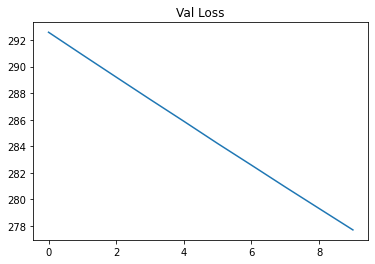

In [32]:
plt.plot(afghan_model.history.history['val_loss'])
plt.title('Val Loss')

In [33]:
afghan_model = load_model('afghan_model/')
afghan_train_predictions = afghan_model.predict(afghanistan_X_train).flatten()
afghan_train_results = pd.DataFrame(data={'Train Predictions': afghan_train_predictions, 'Actuals':afghanistan_y_train})
# afghan_train_results

59/59 [==============================] - 1s 5ms/step


In [34]:
afghan_test_predictions = afghan_model.predict(afghanistan_X_test).flatten()
afghan_test_results = pd.DataFrame(data={'Test Predictions': afghan_test_predictions, 'Actuals':afghanistan_y_test})
afghan_test_results["Difference"] = abs(afghan_test_results["Actuals"] - afghan_test_results["Test Predictions"])
afghan_average_accuracy = afghan_test_results["Difference"].mean()
print("On Average, the mean difference between our predictions and actuals for our", len(afghan_test_results), "test data points is:", afghan_average_accuracy)

4/4 [==============================] - 0s 6ms/step
On Average, the mean difference between our predictions and actuals for our 121 test data points is: 14.367012060149642


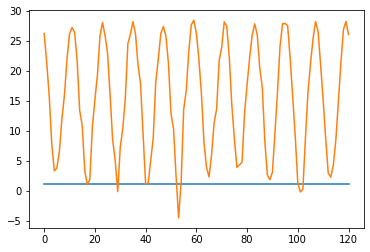

In [35]:
plt.plot(afghan_test_results['Test Predictions'])
plt.plot(afghan_test_results['Actuals'])

# Bangladesh

In [36]:
bangladesh_final, bangladesh_final_temp_only = clean_df(bangladesh)
# bangladesh_final.head()
WINDOW_SIZE = 5
bangladesh_X, bangladesh_y = df_to_X_y(bangladesh_final_temp_only, WINDOW_SIZE)
bangladesh_X.shape, bangladesh_y.shape

((2524, 5, 1), (2524,))

In [37]:
bangladesh_train_len, bangladesh_val_len, bangladesh_test_len = get_lengths(bangladesh_final_temp_only)
print(bangladesh_train_len, bangladesh_val_len, bangladesh_test_len)
bangladesh_X_train, bangladesh_y_train = bangladesh_X[:bangladesh_train_len], bangladesh_y[:bangladesh_train_len]
bangladesh_X_val, bangladesh_y_val = bangladesh_X[bangladesh_train_len:(bangladesh_val_len+bangladesh_train_len)], bangladesh_y[bangladesh_train_len:(bangladesh_val_len+bangladesh_train_len)]
bangladesh_X_test, bangladesh_y_test = bangladesh_X[(bangladesh_val_len+bangladesh_train_len):], bangladesh_y[(bangladesh_val_len+bangladesh_train_len):]
bangladesh_X_train.shape, bangladesh_y_train.shape, bangladesh_X_val.shape, bangladesh_y_val.shape, bangladesh_X_test.shape, bangladesh_y_test.shape

2276 101 151


((2276, 5, 1), (2276,), (101, 5, 1), (101,), (147, 5, 1), (147,))

In [38]:
bangladesh_model = Sequential()
bangladesh_model.add(InputLayer((5,1)))
bangladesh_model.add(LSTM(64))
bangladesh_model.add(Dense(8, 'relu'))
bangladesh_model.add(Dense(1, 'linear'))

bangladesh_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [39]:
bangladesh_cp = ModelCheckpoint('bangladesh_model/', save_best_only=True)
bangladesh_history = History()
bangladesh_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [40]:
bangladesh_model.fit(bangladesh_X_train, bangladesh_y_train, validation_data=(bangladesh_X_val, bangladesh_y_val), epochs=10, callbacks=[bangladesh_cp, bangladesh_history])

Epoch 1/10
71/72 [============================>.] - ETA: 0s - loss: 571.2119 - root_mean_squared_error: 23.9000

72/72 [==============================] - 8s 88ms/step - loss: 570.9965 - root_mean_squared_error: 23.8955 - val_loss: 477.4702 - val_root_mean_squared_error: 21.8511
Epoch 2/10
71/72 [============================>.] - ETA: 0s - loss: 315.4737 - root_mean_squared_error: 17.7616

72/72 [==============================] - 5s 72ms/step - loss: 315.2240 - root_mean_squared_error: 17.7545 - val_loss: 178.9955 - val_root_mean_squared_error: 13.3789
Epoch 3/10
67/72 [==========================>...] - ETA: 0s - loss: 87.8495 - root_mean_squared_error: 9.3728

72/72 [==============================] - 5s 75ms/step - loss: 84.6480 - root_mean_squared_error: 9.2004 - val_loss: 34.8172 - val_root_mean_squared_error: 5.9006
Epoch 4/10
64/72 [=========================>....] - ETA: 0s - loss: 19.9737 - root_mean_squared_error: 4.4692

72/72 [==============================] - 6s 86ms/step - loss: 19.5356 - root_mean_squared_error: 4.4199 - val_loss: 15.1615 - val_root_mean_squared_error: 3.8938
Epoch 5/10
69/72 [===========================>..] - ETA: 0s - loss: 14.8342 - root_mean_squared_error: 3.8515

72/72 [==============================] - 5s 74ms/step - loss: 14.8044 - root_mean_squared_error: 3.8477 - val_loss: 14.3563 - val_root_mean_squared_error: 3.7890
Epoch 6/10
72/72 [==============================] - ETA: 0s - loss: 14.7324 - root_mean_squared_error: 3.8383

72/72 [==============================] - 5s 71ms/step - loss: 14.7324 - root_mean_squared_error: 3.8383 - val_loss: 14.2440 - val_root_mean_squared_error: 3.7741
Epoch 7/10
70/72 [============================>.] - ETA: 0s - loss: 14.3066 - root_mean_squared_error: 3.7824

72/72 [==============================] - 7s 98ms/step - loss: 14.3046 - root_mean_squared_error: 3.7821 - val_loss: 13.7973 - val_root_mean_squared_error: 3.7145
Epoch 8/10
71/72 [============================>.] - ETA: 0s - loss: 12.6873 - root_mean_squared_error: 3.5619

72/72 [==============================] - 5s 73ms/step - loss: 12.6976 - root_mean_squared_error: 3.5634 - val_loss: 11.5065 - val_root_mean_squared_error: 3.3921
Epoch 9/10
70/72 [============================>.] - ETA: 0s - loss: 9.7397 - root_mean_squared_error: 3.1209

72/72 [==============================] - 5s 73ms/step - loss: 9.6817 - root_mean_squared_error: 3.1115 - val_loss: 7.9236 - val_root_mean_squared_error: 2.8149
Epoch 10/10
72/72 [==============================] - ETA: 0s - loss: 6.7491 - root_mean_squared_error: 2.5979

72/72 [==============================] - 6s 85ms/step - loss: 6.7491 - root_mean_squared_error: 2.5979 - val_loss: 5.6558 - val_root_mean_squared_error: 2.3782


Text(0.5, 1.0, 'Val Loss')

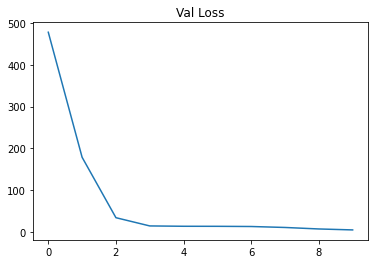

In [41]:
plt.plot(bangladesh_model.history.history['val_loss'])
plt.title('Val Loss')

In [42]:
bangladesh_model = load_model('bangladesh_model/')
bangladesh_train_predictions = bangladesh_model.predict(bangladesh_X_train).flatten()
bangladesh_train_results = pd.DataFrame(data={'Train Predictions': bangladesh_train_predictions, 'Actuals':bangladesh_y_train})
# afghan_train_results

72/72 [==============================] - 1s 3ms/step


In [43]:
bangladesh_test_predictions = bangladesh_model.predict(bangladesh_X_test).flatten()
bangladesh_test_results = pd.DataFrame(data={'Test Predictions': bangladesh_test_predictions, 'Actuals':bangladesh_y_test})
bangladesh_test_results["Difference"] = abs(bangladesh_test_results["Actuals"] - bangladesh_test_results["Test Predictions"])
bangladesh_average_accuracy = bangladesh_test_results["Difference"].mean()
print("On Average, the mean difference between our predictions and actuals for our", len(bangladesh_test_results), "test data points is:", bangladesh_average_accuracy)

5/5 [==============================] - 0s 4ms/step
On Average, the mean difference between our predictions and actuals for our 147 test data points is: 2.1728771744293427


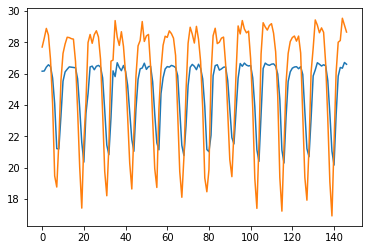

In [45]:
plt.plot(bangladesh_test_results['Test Predictions'])
plt.plot(bangladesh_test_results['Actuals'])

# Chad

In [28]:
chad_final, chad_final_temp_only = clean_df(chad)
chad_final.head()

,Date,AverageTemperature
106355,1856-01-01,21.544
106356,1856-02-01,22.771
106357,1856-03-01,26.617
106358,1856-04-01,29.054
106359,1856-05-01,30.311


 # Haiti

In [29]:
haiti_final, haiti_final_temp_only = clean_df(haiti)
haiti_final.head()

,Date,AverageTemperature
229802,1824-01-01,24.987
229803,1824-02-01,23.994
229804,1824-03-01,25.808
229805,1824-04-01,25.650
229806,1824-05-01,26.703
